# Week 4


### Problem Description

When deciding to open a restaurant, location is one of the biggest key factors influencing the success of the business. Given this small detail has such a high impact on the restaurant survivability, every businessman would be interested to know a priori where they should build their business. Which places have a higher tendency to lead to success and which ones are doomed to fail. 

To have a general idea of what the problem entails, let us think about what type of location would be ideal. The new installations need to be in a good neighbourhood, one which is relatively quiet, but simultaneously crowded and with a sizeable crowd in order to increase the chances to find costumers. Moreover, it is best not to have too many restaurants around in order to decrease the competition between the different food establishments, but while also avoiding empty areas, or areas that are not associated with the business at hand.

Overall, there is no ideal neighbourhood and there are no hard constraints. One needs to find the equilibrium between the different requirements. So as to solve the problem present, in this project we will develop and approach that relies on machine learning and data extraction tools in order to figure out whether a certain neighbourhood has potential for us to build our restaurant.


### Data description

The study will focus on the area of Lisbon.

We will extract data from the listo of top 30 restaurants in Lisbon along with their addresses, from the zomato website (https://www.zomato.com/), as well as the list of bottom 30 restaurants (in ordert o have a means of comparison).

We will be using the tool foursquare, in order to get the location data from each restaurant.


### Methodology

Having the Adresses and the respective location data from the restaurants, it will be necessary to properly clean it and prepare it for posterior analysis.

Afterwards, we will be able to compare the data obtained from foursquare and try to identify trends among the similar restaurantes and differences between the two different kinds. 

Moreover, we will be able to build machine learning models, such as decision trees, that will help us determine wether or not a certain location is fit to have a new restaurant.


# Week 5

NOTE: The maps in the notebook are not shown if seen from github directly. Please download the notebook, and set select the 'Trust Notebook' from the File menu to see the maps.

## Results

### Import Required Libraries

In [4]:
# Imports
import pandas as pd

#!pip install geocoder
import geocoder

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!pip install folium
import folium # map rendering library

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import preprocessing

### Data Collection

Dataframe with top 15 restaurants from Lissabon (Label = 1) and bottom 15 restaurants from Lissabon (Label = 0)

In [5]:

columns = ["Address", "Name", "Label"]
data = [
        ["1600-488 Lisboa", "Volver de Carne Y Alma", 1],
        ["1150-017 Lisboa", "Ramiro", 1],
        ["1250-096 Lisboa", "Yakuza First Floor", 1],
        ["1050-149 Lisboa", "Go Juu", 1],
        ["1200-443 Lisboa", "Belcanto", 1],
        ["1200-027 Lisboa", "Mini Bar", 1],
        ["1050-241 Lisboa", "Nomada", 1],
        ["2620-515 Ramada", "Tutto Combinato", 1],
        ["1250-095 Lisboa", "A Cevicheria", 1],
        ["1200-334 Lisboa", "Bistro 100 Maneiras", 1],
        ["1200-023 Lisboa", "Alma", 1],
        ["2710-175 Sintra", "Tybuas", 1],
        ["1200-369 Lisboa", "Boa-Bao", 1],
        ["1250-039 Lisboa", "Forno d'Oro", 1],
        ["2775-551 Carcavelos", "Marino", 0],
        ["1900-806 Lisboa", "Chines Jingly", 0],
        ["1100-061 Lisboa", "Heaven's Door", 0],
        ["2710-616 Sintra", "Cafe da Villa", 0],
        ["2750-642 Cascais", "Flamingo Cafe", 0],
        ["1700-094 Lisboa", "Tatu", 0],
        ["1050-170 Lisboa", "Maracan’", 0],
        ["1200-043 Lisboa", "Espa?o Acad?mico de Lisboa", 0],
        ["1000-139 Lisboa", "Osaka", 0],
        ["2690-264 Santa Iria De Azoia", "O Tolan", 0],
        ["2900-454 Setubal", "Saca Rolhas", 0],
        ["2825-343 Costa da Caparica", "BBQ - Casa de Petiscos", 0],
        ["2705-334 Colares", "Casa da Gal", 0],
        ["1750-006 Lisboa", "Groovy", 0],
        ["2800-270 Almada", "O Peralta", 0]
]

df = pd.DataFrame(data, columns=columns)

df.head()

,Address,Name,Label
0,1600-488 Lisboa,Volver de Carne Y Alma,1
1,1150-017 Lisboa,Ramiro,1
2,1250-096 Lisboa,Yakuza First Floor,1
3,1050-149 Lisboa,Go Juu,1
4,1200-443 Lisboa,Belcanto,1


Get Latitude/Longitude of different restaurants

In [6]:
latitude=[]
longitude=[]
for code in df['Address']:
    g = geocoder.arcgis('{}, Lisboa, Portugal'.format(code))
    while (g.latlng is None):
        g = geocoder.arcgis('{}, Lisboa, Portugal'.format(code))
    latlng = g.latlng
    latitude.append(latlng[0])
    longitude.append(latlng[1])

Add columns with latitude and longitude to dataframe

In [7]:

df["Latitude"] = latitude
df["Longitude"] = longitude

df.head()

,Address,Name,Label,Latitude,Longitude
0,1600-488 Lisboa,Volver de Carne Y Alma,1,38.771081,-9.162281
1,1150-017 Lisboa,Ramiro,1,38.721504,-9.135401
2,1250-096 Lisboa,Yakuza First Floor,1,38.717896,-9.161970
3,1050-149 Lisboa,Go Juu,1,38.735616,-9.152228
4,1200-443 Lisboa,Belcanto,1,38.710550,-9.141636


Visualize restaurants coordinates in a folium map

In [8]:
address = 'Lisboa'

geolocator = Nominatim(user_agent="TO_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Lissabon are {}, {}.'.format(latitude, longitude))
print("Points in blue correspond to the restaurants with high score.")
print("Whereas points in red correspond to the restaurants with low score.")

# create map of New York using latitude and longitude values
map_lisboa = folium.Map(location=[latitude, longitude], zoom_start=11)

colors = ['red', 'blue']

# add markers to map
for lat, lng, address, label_id in zip(df['Latitude'], df['Longitude'], df['Address'], df['Label']):
    label = '{}'.format(address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[label_id],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lisboa)  
    
map_lisboa

The geograpical coordinate of Lissabon are 38.7077507, -9.1365919.
Points in blue correspond to the restaurants with high score.
Whereas points in red correspond to the restaurants with low score.


Auxiliar function that will fetch venues data from foursquare

In [9]:
# Credentials

CLIENT_ID = "KDQEC0PX5X3IWTEHQ2G1VQ1O2CSGZKSQF1VQ32UFSITXP3JY"
CLIENT_SECRET = "N2N0WPYWLEZRFXLJL4FDT30FQLVERQ2MNPRD4QHJAJDXPWX5"
VERSION = '20180604'

In [10]:

def getNearbyVenues(names, latitudes, longitudes, radius=500, limit = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Address', 
                              'Address Latitude', 
                              'Address Longitude', 
                              'Venue', 
                              'Venue Latitude', 
                              'Venue Longitude', 
                              'Venue Category']
    
    return(nearby_venues)

Get venues associated to each postal code (each restaurant)

In [11]:

df_venues = getNearbyVenues(names=df['Address'],
                            latitudes=df['Latitude'],
                            longitudes=df['Longitude']
                           )
df_venues.head()


,Address,Address Latitude,Address Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1600-488 Lisboa,38.771081,-9.162281,Volver By Chakall,38.770113,-9.160823,Argentinian Restaurant
1,1600-488 Lisboa,38.771081,-9.162281,O Trenó,38.772394,-9.160767,Bakery
2,1600-488 Lisboa,38.771081,-9.162281,A Padaria Portuguesa,38.771939,-9.160664,Bakery
3,1600-488 Lisboa,38.771081,-9.162281,Frangos do Rei,38.770299,-9.159810,BBQ Joint
4,1600-488 Lisboa,38.771081,-9.162281,Volver,38.770113,-9.160675,Restaurant


### Data Cleaning

After loading the data from the different required sources, it is important to clean the data and change their formats accordingly

In [12]:
df['Label'] = df['Label'].astype(int)

One hot encoding the venue data will allow us to divide the categorical data into binary one (which will facilitate the classification done further on)

In [13]:
# One hot encoding
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['Address'] = df_venues['Address'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot.head()

,Address,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Thrift / Vintage Store,Tibetan Restaurant,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store
0,1600-488 Lisboa,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1600-488 Lisboa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1600-488 Lisboa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1600-488 Lisboa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1600-488 Lisboa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


After one hot encoding, it is necessary to group the data obtained from each venue. This way for each address, we will have all the information condensed allong the different features.

In [14]:
df_grouped = df_onehot.groupby('Address').mean().reset_index()

# Drop Addres column,since it is no longer required

df_grouped = df_grouped.drop('Address', 1)

The grouped data can be visualized as an histogram

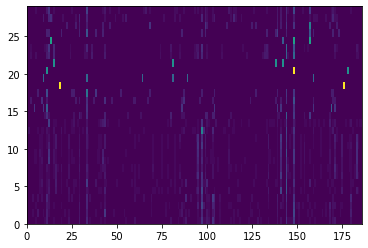

In [15]:
# Visualize df_grouped

plt.pcolor(df_grouped)
plt.show()

As it is possible to see, the data is quite sparse

We can also analyse the statistics of the data using the describe method from pandas

In [16]:
df_grouped.describe()

,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,...,Thrift / Vintage Store,Tibetan Restaurant,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,...,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,0.000737,0.000704,0.002104,0.001048,0.003153,0.002443,0.003180,0.003184,0.006712,0.010146,...,0.017241,0.000392,0.008966,0.002116,0.009316,0.000778,0.000690,0.014274,0.002406,0.000392
std,0.002761,0.003790,0.006813,0.003957,0.013381,0.005025,0.009024,0.005537,0.012833,0.033406,...,0.092848,0.002110,0.046395,0.004223,0.013200,0.002922,0.002579,0.022650,0.004942,0.002110
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.012346,0.000000,0.000000,0.025641,0.000000,0.000000
max,0.011364,0.020408,0.031250,0.017241,0.071429,0.016949,0.038462,0.020000,0.062500,0.166667,...,0.500000,0.011364,0.250000,0.011364,0.051724,0.012346,0.010000,0.060000,0.016949,0.011364


In order to improve the accuracy of the models it is important to scale all our data.

In this case I will be using the MinMaxScaler from sklearn library

In [17]:

x = df_grouped.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_grouped = pd.DataFrame(x_scaled)


Visualizing the data with the use of a heat map after scaling it

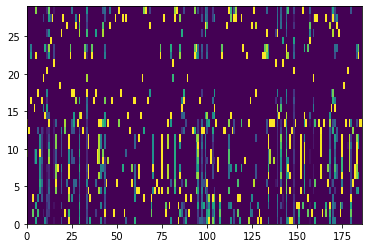

In [18]:
plt.pcolor(df_grouped)
plt.show()

In [19]:
df_grouped.describe()

,0,1,2,3,4,5,6,7,8,9,...,176,177,178,179,180,181,182,183,184,185
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,...,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,0.064828,0.034483,0.067332,0.060799,0.044138,0.144119,0.082683,0.159217,0.107386,0.060878,...,0.034483,0.034483,0.035862,0.186207,0.180106,0.062984,0.068966,0.237904,0.141945,0.034483
std,0.242938,0.185695,0.218027,0.229535,0.187341,0.296501,0.234614,0.276837,0.205323,0.200435,...,0.185695,0.185695,0.185579,0.371603,0.255198,0.236652,0.257881,0.377505,0.291563,0.185695
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.160000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.238683,0.000000,0.000000,0.427350,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Classification

Divide dataset into train and test data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_grouped.values, df["Label"].values, test_size=0.33, random_state=42)

print(X_train.shape)
print(X_test.shape)

(19, 186)
(10, 186)


##### Decision Tree Classifier

In [23]:

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)


In [24]:

# Model Accuracy, how often is the classifier correct?
print("Accuracy using decision trees:",metrics.accuracy_score(y_test, y_pred))


Accuracy using decision trees: 0.9


##### Support Vector Machine (SVM)

In [25]:

# Create SVM classifer object
clf = svm.SVC()

# Train SVM Classifer
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)


In [26]:
print("Accuracy using SVM:",metrics.accuracy_score(y_test, y_pred))

Accuracy using SVM: 0.9


### Discussion

As it is possible to see, we were able to obtain an accuracy of 90% using both Decision trees and SVM. This shows how promising this new method to classify new locations for restaurants.

However it is important to keep in mind that the current dataset was quite small and in order to get more realistic results a much larger one should be used. Such low quantity of data entries and high amount of features may lead to overfitting, that due to the low amount of data is not visible.

Moreover, adding another features besides the location data would also be ideal (these features could include the average cost per person, type of cuisine...)

### Conclusion

Overall this project was quite useful. It allowed to put into practice everything learned along all the project's progress.

Regarding the results obtained they seem good, but due to the low quantity of data, no real conclusion can be made. At most its usefullness falls on the essential train acquired to derive those results.
